# Jupyter Notebook: Regression mit einem Multi Layer Perceptron in PyTorch

In diesem Notebook erstellen wir ein Multi Layer Perceptron (MLP) mit PyTorch, um eine Regressionsaufgabe auf dem California Housing Dataset zu lösen. Der Datensatz enthält Merkmale wie Medianalter des Hauses, Anzahl der Zimmer und Einkommen der Nachbarschaft, um den Medianhauspreis (kontinuierlich) vorherzusagen. Wir integrieren CUDA-Unterstützung für GPU-Beschleunigung, falls verfügbar, und visualisieren die Trainings- und Validierungsverluste. Am Ende evaluieren wir das Modell mit Metriken wie Mean Squared Error (MSE), Mean Absolute Error (MAE) und R² Score und erstellen einen Scatter-Plot der vorhergesagten vs. tatsächlichen Werte.

Das Notebook ist in folgende Abschnitte gegliedert:
1. Datenvorbereitung: Laden und Skalieren des Datensatzes.
2. PyTorch Datasets und Dataloaders: Daten für PyTorch vorbereiten.
3. MLP-Modell: Definition eines einfachen MLP für Regression.
4. Training: Training mit MSE Loss und Visualisierung der Verluste.
5. Evaluation: Berechnung von Metriken und Visualisierung der Ergebnisse.

## 1. Datenvorbereitung

Wir laden den California Housing Dataset und skalieren die Daten, um die Modellleistung zu optimieren.

## 1.1 Datensatz laden

In [13]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Datensatz laden
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # Zielvariable: Medianhauspreis in 100.000 USD

# Erste Zeilen anzeigen
print(X.head())
print(f"Zielvariable (erste 5 Werte): {y[:5]}")

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
Zielvariable (erste 5 Werte): [4.526 3.585 3.521 3.413 3.422]


### 1.2 Daten aufteilen

Wir teilen die Daten in Trainings- (70%), Validierungs- (15%) und Testsets (15%).

In [2]:
from sklearn.model_selection import train_test_split

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Aufteilung des Trainingsdatensatzes in Trainings- und Validierungsdaten
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

### 1.3 Daten skalieren

Wir standardisieren die Merkmale und die Zielvariable mit StandardScaler.

In [3]:
from sklearn.preprocessing import StandardScaler

# Skalierung der Merkmale
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Skalierung der Zielvariable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

## 2. Erstellen von PyTorch Datasets und Dataloaders

Wir wandeln die Daten in PyTorch-Tensoren um und erstellen Dataloaders für effizientes Training.

### 2.1 Benutzerdefiniertes Dataset

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)  # Float für Regression

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Datasets erstellen
train_dataset = HousingDataset(X_train, y_train)
val_dataset = HousingDataset(X_val, y_val)
test_dataset = HousingDataset(X_test, y_test)

## 2.2 Dataloaders

Wir nutzen pin_memory=True für schnellere Datenübertragung zur GPU, falls CUDA verfügbar ist.

In [6]:
# Gerät bestimmen (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwendetes Gerät: {device}")

batch_size = 64

# Dataloaders erstellen
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory= device != "cpu")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory= device != "cpu")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory= device != "cpu")

Verwendetes Gerät: cpu


## 3. Definition des MLP-Modells

Unser MLP hat eine Eingabeschicht, eine versteckte Schicht mit ReLU-Aktivierung und eine Ausgabeschicht für Regression.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Parameter
input_size = X_train.shape[1]  # Anzahl der Features
hidden_size = 64
output_size = 1  # Regression: ein kontinuierlicher Wert

# Modell instanziieren und auf das Gerät verschieben
model = MLP(input_size, hidden_size, output_size).to(device)

### 4.1 Funktion zum Plotten der Verluste

Wir definieren eine Funktion, die die Trainings- und Validierungsverluste über die Epochen hinweg speichert und einen Plot erstellt.

In [8]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Trainings- und Validierungsverluste über Epochen')
    plt.legend()
    plt.grid(True)
    plt.show()

### 4.2 Trainingsschleife

/Users/nils/projects/fom/repos/exercise-fom-ai-bi/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/30, Train Loss: 0.5086, Val Loss: 0.3619
Epoch 2/30, Train Loss: 0.3431, Val Loss: 0.3164
Epoch 3/30, Train Loss: 0.3135, Val Loss: 0.2982
Epoch 4/30, Train Loss: 0.2986, Val Loss: 0.2832
Epoch 5/30, Train Loss: 0.2851, Val Loss: 0.2773
Epoch 6/30, Train Loss: 0.2770, Val Loss: 0.2728
Epoch 7/30, Train Loss: 0.2719, Val Loss: 0.2706
Epoch 8/30, Train Loss: 0.2694, Val Loss: 0.2786
Epoch 9/30, Train Loss: 0.2794, Val Loss: 0.2565
Epoch 10/30, Train Loss: 0.2594, Val Loss: 0.2585
Epoch 11/30, Train Loss: 0.2566, Val Loss: 0.2529
Epoch 12/30, Train Loss: 0.2579, Val Loss: 0.2490
Epoch 13/30, Train Loss: 0.2500, Val Loss: 0.2517
Epoch 14/30, Train Loss: 0.2499, Val Loss: 0.2453
Epoch 15/30, Train Loss: 0.2516, Val Loss: 0.2490
Epoch 16/30, Train Loss: 0.2449, Val Loss: 0.2472
Epoch 17/30, Train Loss: 0.2474, Val Loss: 0.2468
Epoch 18/30, Train Loss: 0.2432, Val Loss: 0.2398
Epoch 19/30, Train Loss: 0.2406, Val Loss: 0.2509
Epoch 20/30, Train Loss: 0.2605, Val Loss: 0.2483
Epoch 21/

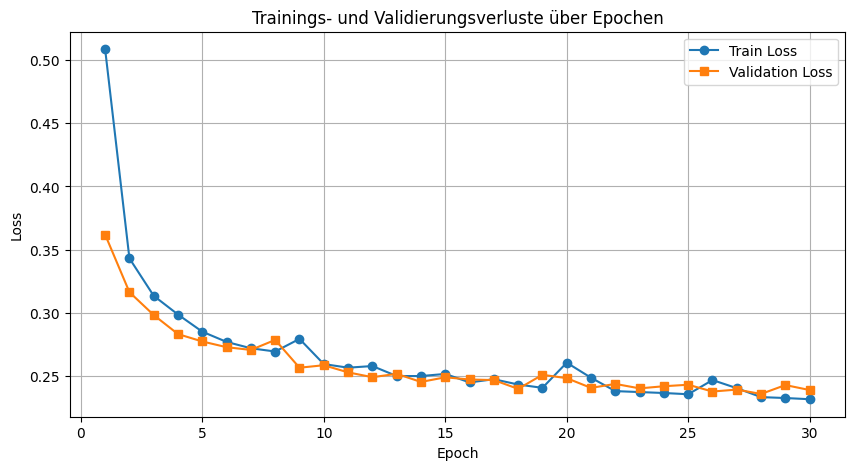

In [30]:
import torch.optim as optim

# Loss-Funktion und Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

# Trainingsparameter
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward Pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        # Backward Pass und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validierung
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Verluste plotten
plot_losses(train_losses, val_losses, num_epochs)

## 5. Evaluation des Modells

Wir evaluieren das Modell auf dem Testset mit MSE, MAE und R² Score und visualisieren die Ergebnisse.

### 5.1 Metriken berechnen

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Modell evaluieren
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Zurückskalieren
all_preds = scaler_y.inverse_transform(np.array(all_preds).reshape(-1, 1)).flatten()
all_labels = scaler_y.inverse_transform(np.array(all_labels).reshape(-1, 1)).flatten()

# Metriken berechnen
mse = mean_squared_error(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.3307
Mean Absolute Error (MAE): 0.3986
R² Score: 0.7477


/Users/nils/projects/fom/repos/exercise-fom-ai-bi/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### 5.2 Scatter-Plot der Ergebnisse

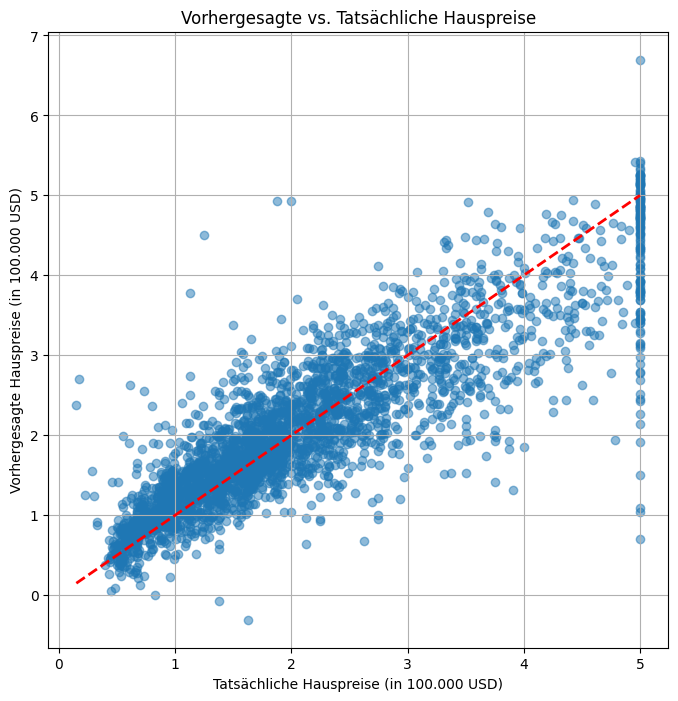

In [32]:
# Scatter-Plot
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--', lw=2)
plt.xlabel('Tatsächliche Hauspreise (in 100.000 USD)')
plt.ylabel('Vorhergesagte Hauspreise (in 100.000 USD)')
plt.title('Vorhergesagte vs. Tatsächliche Hauspreise')
plt.grid(True)
plt.show()